<a href="https://colab.research.google.com/github/tamakoma1129/ClassificationOfDrumSound/blob/main/%E3%83%89%E3%83%A9%E3%83%A0%E9%9F%B3%E6%BA%90%E3%81%AE%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

wav音声ファイルをMFCCファイルに変換

In [8]:
import os
import glob
import numpy as np
import librosa

#wavファイルをmfccにして、numpy配列で保存

# 対象とするフォルダのパスを指定
folder_path = "/content/drive/My Drive/..."

# フォルダ内の全てのwavファイルに対して処理を行います
for filename in glob.glob(os.path.join(folder_path, '*.wav')):
    # 音声ファイルの読み込み
    y, sr = librosa.load(filename, sr=None) #sr=Noneにすることでオリジナルサンプリングレートで読み込む

    # MFCCの計算
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13) #13次元を指定しているが、とりあえずなので後から修正も

    # MFCCsを'.npy'ファイルとして保存
    # ファイル名から拡張子を除いたものに'_mfccs.npy'を付けた名前で保存します
    np.save(os.path.splitext(filename)[0] + '_mfccs.npy', mfccs)

各データの長さを見る

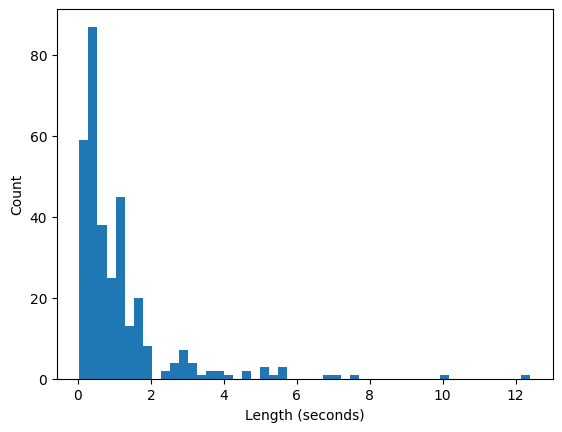

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import librosa

# すべてのファイルパスを取得します
file_paths = glob.glob(os.path.join("/content/drive/MyDrive/ドラム音源の分類/data", '*', '*.wav'))

# 各音声ファイルの長さ（秒）を格納するリスト
lengths = []

# 各ファイルの長さを計算します
for file_path in file_paths:
    y, sr = librosa.load(file_path, sr=None)
    length = librosa.get_duration(y=y, sr=sr)
    lengths.append(length)

# numpy arrayに変換します
lengths = np.array(lengths)

# ヒストグラムを表示します
plt.hist(lengths, bins=50)
plt.xlabel('Length (seconds)')
plt.ylabel('Count')
plt.show()


Accuracy:  0.8507462686567164
Accuracy:  0.7910447761194029
Accuracy:  0.8955223880597015
Accuracy:  0.8656716417910447
Accuracy:  0.8656716417910447
Accuracy:  0.8507462686567164
Accuracy:  0.8805970149253731
Accuracy:  0.8059701492537313
Accuracy:  0.835820895522388
Accuracy:  0.8805970149253731
Accuracy:  0.8059701492537313
Accuracy:  0.8955223880597015
Accuracy:  0.7761194029850746
Accuracy:  0.8507462686567164
Accuracy:  0.835820895522388
Accuracy:  0.7910447761194029
Accuracy:  0.835820895522388
Accuracy:  0.8208955223880597
Accuracy:  0.8059701492537313
Accuracy:  0.8208955223880597
Accuracy:  0.8059701492537313
Accuracy:  0.8955223880597015
Accuracy:  0.9104477611940298
Accuracy:  0.8507462686567164
Accuracy:  0.8507462686567164
Accuracy:  0.7910447761194029
Accuracy:  0.8507462686567164
Accuracy:  0.8059701492537313
Accuracy:  0.7761194029850746
Accuracy:  0.8059701492537313
Accuracy:  0.835820895522388
Accuracy:  0.8059701492537313
Accuracy:  0.8507462686567164
Accuracy:  0.7

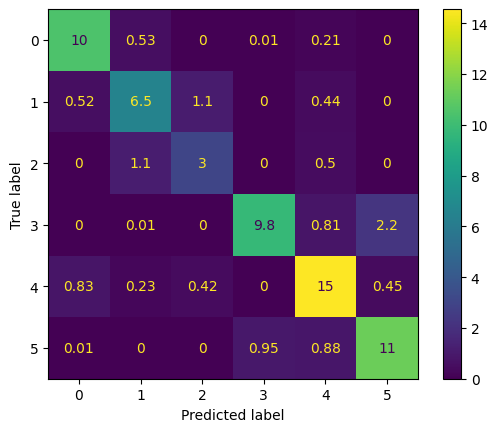

0:CHihat
1:OHihat
2:crash
3:kick
4:snare
5:tom


In [77]:
import os
import glob
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import librosa
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

max_length = int(44100 * 0.2)  # 今回は6秒でパディングするので、44100Hz*6

def load_and_pad(file_path):
    y, sr = librosa.load(file_path, sr=None)
    if len(y) > max_length:
        y = y[:max_length]  # If もし長ければ切る
    else:
        y = np.pad(y, (0, max_length - len(y)))  # もし短ければ増やす
    return y

# フォルダ名とそのラベルを格納するリスト
data = []
labels = []

# フォルダのパスを指定します (e.g., "/content/drive/My Drive/A/data/")
base_folder_path = "/content/drive/MyDrive/ドラム音源の分類/data"

# フォルダ内のサブフォルダ（ジャンル）を一つひとつ見ていきます
for genre_folder in os.listdir(base_folder_path):
    # サブフォルダ内の全ての.wavファイルに対して処理を行います
    for filename in glob.glob(os.path.join(base_folder_path, genre_folder, '*.wav')):
        # 音声ファイルの読み込みとパディング
        y = load_and_pad(filename)
        # MFCCの計算
        mfccs = librosa.feature.mfcc(y=y, sr=176400, n_mfcc=40)
        data.append(mfccs.flatten())  # SVMの入力に合わせデータをフラット化します
        labels.append(genre_folder)  # フォルダ名（ジャンル名）をラベルとして追加

# ラベル（ジャンル名）を数値に変換します。例えば、'CHihat' -> 0, 'OHihat' -> 1のような変換を行います
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

accuracy100 = 0
accuracy_list = []
cm100 = np.zeros((len(encoder.classes_), len(encoder.classes_)))
for _ in range(100):
  # データとラベルを訓練データとテストデータに分割します
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=random.randint(1,10000))

  # SVMのモデルを作成し、訓練データで学習します
  model = svm.SVC()
  model.fit(X_train, y_train)

  # テストデータでモデルの精度を確認します
  accuracy = model.score(X_test, y_test)
  accuracy_list.append(accuracy)
  print("Accuracy: ", accuracy)
  accuracy100+=accuracy
  # テストデータの予測値を得ます
  y_pred = model.predict(X_test)

  # 混同行列を計算し、加算します
  cm = confusion_matrix(y_test, y_pred)
  cm100 += cm


accuracy_std = np.std(accuracy_list)
print("標準偏差: ", accuracy_std)
print("平均正答率",accuracy100/100)
# 混同行列の平均を計算します
cm_avg = cm100 / 100


# 混同行列をプロットします
disp = ConfusionMatrixDisplay(confusion_matrix=cm_avg,display_labels=model.classes_)
disp.plot()
plt.show()
cnt=0
# 各ラベルに対応した名前を表示します
for i in encoder.classes_:
  print(f"{cnt}:{i}")
  cnt+=1